In [17]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt  # to plot
import random
import matplotlib as mpl 

from hardwareModel import HardwareModel
import networkx as nx

from scipy import optimize       # to compare

import seaborn as sns
sns.set(context="talk", style="darkgrid", palette="hls", font="sans-serif", font_scale=1.05)

FIGSIZE = (19, 8)  #: Figure size, in inches!
mpl.rcParams['figure.figsize'] = FIGSIZE
rng = rn.default_rng()

In [18]:
def annealing(positions,
              edges,
              areas,
              interval,
              init_scale,
              maxsteps=10,
              debug=True):
    """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
    for i in range(len(positions)):
        state = init_positions(init_scale)
        positions[i] = state
    
    wireLengths = wirelengths(positions, edges)
    #print(np.sum(list(wireLengths.values())))
    cost = cost_function(wireLengths, positions, areas)
    states, costs = [[] for _ in range(len(positions))], [cost]
    optimalPos = positions.copy()
    minWireLengths = float("inf")
    best = wireLengths.copy()
    
    for step in range(maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction)

        for i in range(len(positions)):
            new_state = random_neighbour(positions[i], interval, areas[i] ** 0.5, fraction)
            positions[i] = new_state
            wireLengths = wirelengths(positions, edges)
            wireLengthSum = np.sum(list(wireLengths.values()))
            new_cost = cost_function(wireLengths, positions, areas)
            #if debug: print("Step #{:>2}/{:>2} : T = {:>4.3g}, state = {:>4.3g}, cost = {:>4.3g}, new_state = {:>4.3g}, new_cost = {:>4.3g} ...".format(step, maxsteps, T, state, cost, new_state, new_cost))
            if acceptance_probability(cost, new_cost, T) > rn.random():
                state, cost = new_state, new_cost
            if wireLengthSum < minWireLengths and overlapCost(positions, areas) == 0:
                minWireLengths = wireLengthSum
                optimalPos = positions.copy()
                best = wireLengths.copy()
                #print('wirelength:', minWireLengths, '|', 'pos:', optimalPos)
            
            states[i].append(state)
            costs.append(new_cost)
        #print("cost:", cost, "|", "new_cost:", new_cost)
        
        #print(np.sum(list(wireLengths.values())))
            # print("  ==> Accept it!")
        # else:
        #    print("  ==> Reject it...")

    print('wirelength:', minWireLengths, '|', 'overlap cost:', overlapCost(optimalPos, areas), '|', 'pos:', optimalPos)
        
    return state, cost_function(wireLengths, positions, areas), states, costs, minWireLengths, optimalPos, best

In [19]:
def wirelengths(x, e):
    repeats = set()
    output = {}

    for edge in e:
        if (edge[1], edge[0]) not in repeats:
            repeats.add(edge)
            position0 = x[edge[0]]
            position1 = x[edge[1]]
            wirelength = ((position0[0] - position1[0]) ** 2 + (position0[1] - position1[1]) ** 2) ** 0.5
            output[edge] = wirelength

    return output

def f(x, positions, areas):
    """ Function to minimize."""
    #print(areas)
    #print("Sum of wirelengths:", np.sum(list(x.values())), "|", "Sum of overlaps:", overlapCost(positions, areas))
    return sum(x.values()) + overlapCost(positions, areas)

def overlap(first, sec, area1, area2):
    s1 = (area1 ** 0.5) / 2
    s2 = (area2 ** 0.5) / 2
    deltaX = min([first[0] + s1, sec[0] + s2]) - max([first[0] - s1, sec[0] - s2])
    deltaY = min((first[1] + s1, sec[1] + s2)) - max((first[1] - s1, sec[1] - s2))
    #print('first square:', (first[0] + s1, first[0] - s1), '|', 'second square:', (sec[0] + s2, sec[0] - s2))
    #print('deltaX:', deltaX, '|', 'deltaY:', deltaY)
    if deltaX < 0 or deltaY < 0:
        return 0
    if deltaX == 0 and deltaY != 0:
        return abs(s1 * deltaY)
    if deltaX != 0 and deltaY == 0:
        return abs(s2 * deltaX)

    #print(deltaX * deltaY)
    
    return deltaX * deltaY

def overlapCost(pVectors, areas, const=1):
    totalCost = 0
    #print(areas)
    
    for i in range(len(pVectors) - 1):
        for j in range(i + 1, len(pVectors)):
            totalCost += overlap(pVectors[i], pVectors[j], areas[i], areas[j])
            #print(totalCost)

    return totalCost

def clip(x):
    """ Force x to be in the interval."""
    a, b = interval
    return max(min(x, b), a)

In [20]:
# def random_start():
#     """ Random point in the interval."""
#     a, b = interval
#     x = a + (b - a) * rn.random_sample()
#     y = a + (b - a) * rn.random_sample()
#     return (x, y)

def init_positions(scale):
    return rng.normal(loc=0.0, scale=scale, size=2)

In [21]:
def cost_function(x, positions, areas):
    """ Cost of x = f(x)."""
    #print(areas)
    return f(x, positions, areas)

In [22]:
def random_neighbour(x, interval, scale, fraction=1):
    """Move a little bit x, from the left or the right."""
    amplitude = (max(interval) - min(interval)) * (1 - fraction) / 10
    deltaX = (-amplitude/2.) + amplitude * rng.normal(loc=0.0, scale=scale, size=None)
    deltaY = (-amplitude/2.) + amplitude * rng.normal(loc=0.0, scale=scale, size=None)
    return (clip(x[0] + deltaX), clip(x[1] + deltaY))

In [23]:
def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        # print("    - Acceptance probabilty = 1 as new_cost = {} < cost = {}...".format(new_cost, cost))
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        # print("    - Acceptance probabilty = {:.3g}...".format(p))
        return p

In [24]:
def temperature(fraction):
    """ Example of temperature dicreasing as the process goes on."""
    return max(0.01, min(1, 1 - fraction))

In [144]:
annealing(positions, edges, areas, maxsteps=30);

wirelength: 3.061761937429099 | overlap cost: 0 | pos: [(-6.328638864849236, -8.95961701362144), (-6.839443388429718, -7.69146870287712), (-4.9909971909924, -10)]


In [145]:
state, c, states, costs, minWireLength, optimalPos, wirelengths = annealing(positions, edges, areas, maxsteps=100000)

print(optimalPos)
#print(overlapCost(optimalPos, areas))

wirelength: 2.0288559297970794 | overlap cost: 0 | pos: [(-10, -10), (-9.859774591162857, -8.989053981884076), (-8.99176888708128, -10)]
[(-10, -10), (-9.859774591162857, -8.989053981884076), (-8.99176888708128, -10)]


In [207]:
def plotter(wirelengths):
    G = nx.Graph()
    edges_with_weights = []
    
    for pair in wirelengths:
        pairUpdated = list(pair)
        pairUpdated.append(wirelengths[pair])
        edges_with_weights.append(pairUpdated)
    
    G.add_weighted_edges_from(edges_with_weights)
    pos = nx.spring_layout(G, weight='weight', iterations=1000, k=0.5/np.sqrt(len(G.nodes())))
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_weight='bold', font_size=16)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

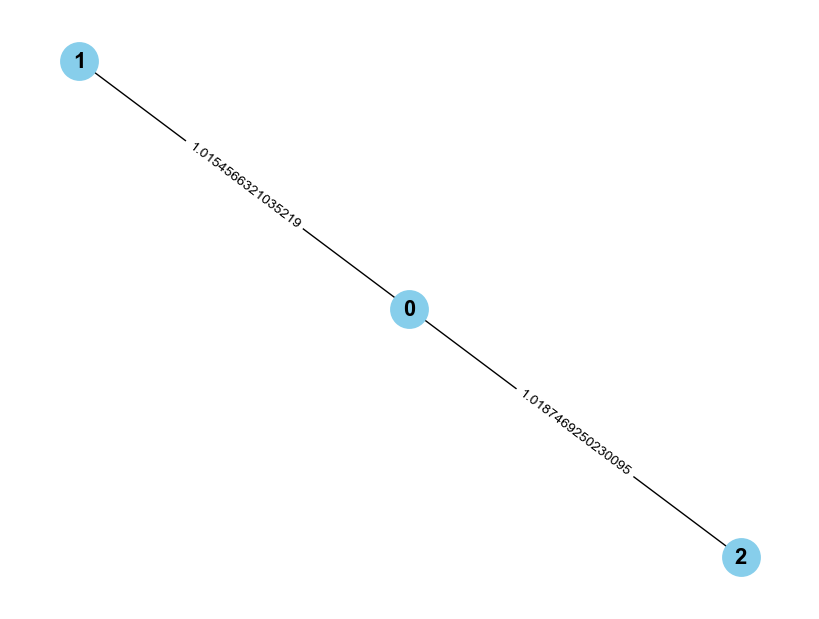

In [122]:
plotter(wirelengths)

In [25]:
hw = HardwareModel(cfg='aladdin_const_with_mem')
digraph = hw.netlist
nodes = digraph.nodes
edges = digraph.edges
node_to_index = {node: i for i, node in enumerate(nodes)}
N = len(nodes)
areas = [None for _ in range(N)]
newEdges = []
averageSide = 0

for node in digraph.nodes.data(True):
    name = node[0]
    function = node[1]['function']
    index = node_to_index[name]
    areas[index] = hw.area[function]
    averageSide += areas[index] ** 0.5
    
for edge in edges:
    if (edge[1], edge[0]) in newEdges:
        continue

    newEdges.append(edge)

areas[6] = 50365000.0
areas[7] = 50365000.0
averageSide /= N
E = [(node_to_index[src], node_to_index[dst]) for src, dst in newEdges]
positions = [(0, 0) for _ in range(N)]
interval = (min(areas), max(areas))

netlist: [('Add0', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}), ('Regs0', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 0}), ('Regs1', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 1}), ('Regs2', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 2}), ('Mult0', {'type': 'pe', 'function': 'Mult', 'in_use': 0, 'idx': 0}), ('Eq0', {'type': 'pe', 'function': 'Eq', 'in_use': 0, 'idx': 0}), ('Buf0', {'type': 'mem', 'function': 'Buf', 'in_use': 0, 'idx': 0, 'size': 22}), ('Buf1', {'type': 'mem', 'function': 'Buf', 'in_use': 0, 'idx': 1, 'size': 22}), ('Mem0', {'type': 'mem', 'function': 'MainMem', 'in_use': 0, 'idx': 0, 'size': 1024}), ('Regs3', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 3})]


In [113]:
state, c, states, costs, minWireLength, optimalPos, wireLengths = annealing(positions, E, areas, interval, averageSide, maxsteps=10000)

wirelength: 81250224659.76541 | overlap cost: 0 | pos: [(2126052942.561299, 8340007000.0), (5080817657.023844, 8074813507.963572), (1442473861.011468, 7173180926.439094), (2924238319.170287, 7058626981.965384), (5981433.0, 7936163824.364987), (8340007000.0, 5860239887.254463), (3186655430.523403, 7193735904.221238), (793576878.5463468, 5496428917.746361), (1524955613.4653044, 8080267586.108952), (8001913912.046063, 1436627776.416069)]


In [140]:
def plotter2(positions, areas, nodes, edges):
    G = nx.Graph()
    nodes = list(nodes)

    for i in range(len(positions)):
        G.add_node(nodes[i], pos=positions[i], size=areas[i] * 10 ** -6.4)

    for edge in edges:
        G.add_edge(nodes[edge[0]], nodes[edge[1]])

    #pos = nx.get_node_attributes(G, 'pos')
    pos = nx.spring_layout(G, pos=nx.get_node_attributes(G, 'pos'), fixed=nx.get_node_attributes(G, 'pos').keys(), seed=1000000000)
    sizes = [G.nodes[node]['size'] for node in G.nodes]
    edge_colors = [plt.cm.viridis(random.uniform(0, 1)) for _ in range(len(edges))]
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=False, node_size=sizes, node_color='skyblue', font_size=10, font_weight='bold', edge_color=edge_colors)
    label_pos = {node: (coords[0] - 300000000, coords[1]) for node, coords in pos.items()}
    #label_pos = {node: (coords[0] - (G.nodes[node]['size'] * 10000000), coords[1]) for node, coords in pos.items()}
    nx.draw_networkx_labels(G, label_pos, font_size=10, font_weight='bold')
    plt.show()

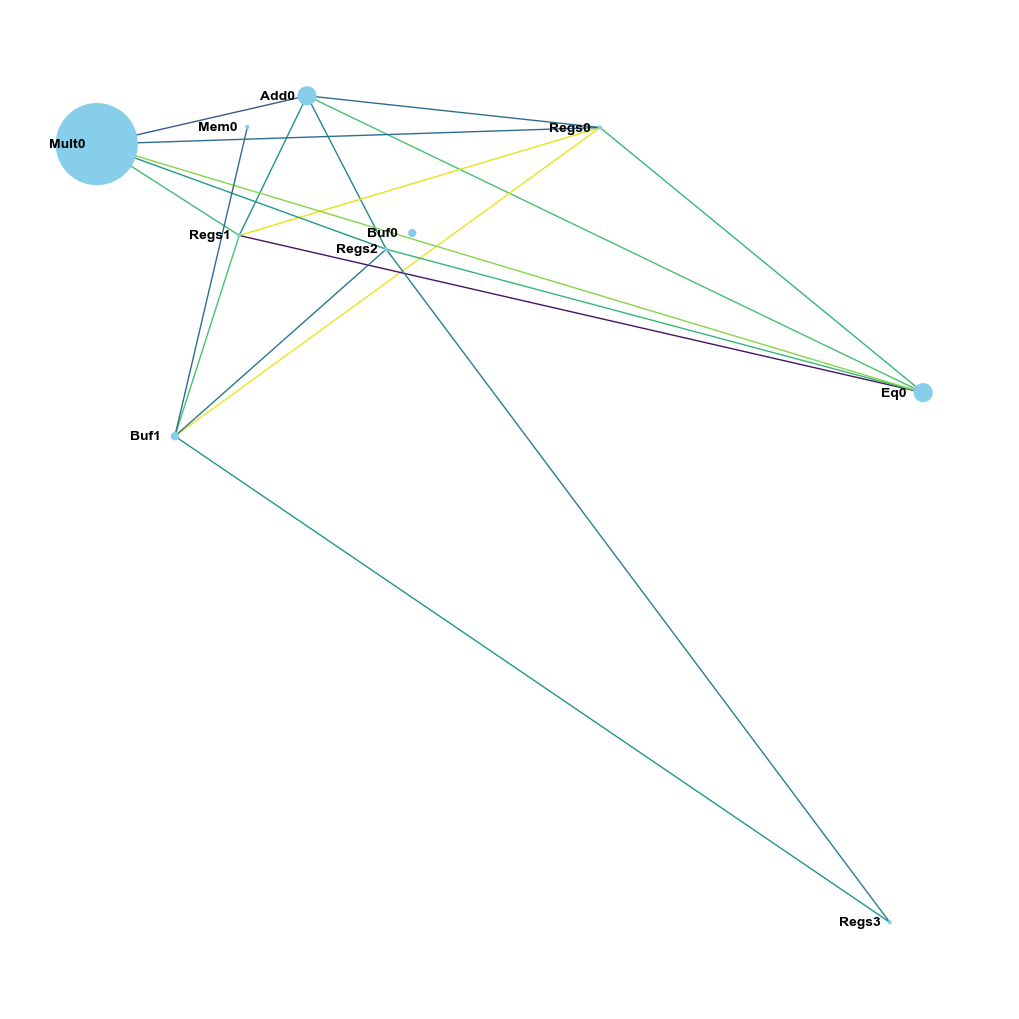

In [141]:
plotter2(optimalPos, areas, nodes, E)

In [29]:
areas

[379348800.0,
 5981433.0,
 5981433.0,
 5981433.0,
 8340007000.0,
 379348800.0,
 50365000.0,
 50365000.0,
 5981433.0,
 5981433.0]

In [142]:
def wrapperAnnealing(cfg='aladdin_const_with_mem'):
    digraph = hw.netlist
    nodes = digraph.nodes
    edges = digraph.edges
    node_to_index = {node: i for i, node in enumerate(nodes)}
    N = len(nodes)
    areas = [None for _ in range(N)]
    newEdges = []
    averageSide = 0
    
    for node in digraph.nodes.data(True):
        name = node[0]
        function = node[1]['function']
        index = node_to_index[name]
        areas[index] = hw.area[function]
        averageSide += areas[index] ** 0.5
        
    for edge in edges:
        if (edge[1], edge[0]) in newEdges:
            continue
    
        newEdges.append(edge)
    
    areas[6] = 50365000.0
    areas[7] = 50365000.0
    averageSide /= N
    E = [(node_to_index[src], node_to_index[dst]) for src, dst in newEdges]
    positions = [(0, 0) for _ in range(N)]
    interval = (min(areas), max(areas))
    state, c, states, costs, minWireLength, optimalPos, wireLengths = annealing(positions, E, areas, interval, averageSide, maxsteps=10000)
    plotter2(optimalPos, areas, nodes, E)

wirelength: 109949656713.87204 | overlap cost: 0 | pos: [(5981433.0, 5415194040.637905), (4780100992.665431, 2659665096.2088313), (5429340582.218685, 6925178080.606009), (5139896830.369327, 8340007000.0), (2757359846.1124907, 8340007000.0), (8340007000.0, 5981433.0), (4131362027.5560737, 8340007000.0), (8340007000.0, 8340007000.0), (5981433.0, 6479042202.276941), (5699516250.251404, 3378525818.1529317)]


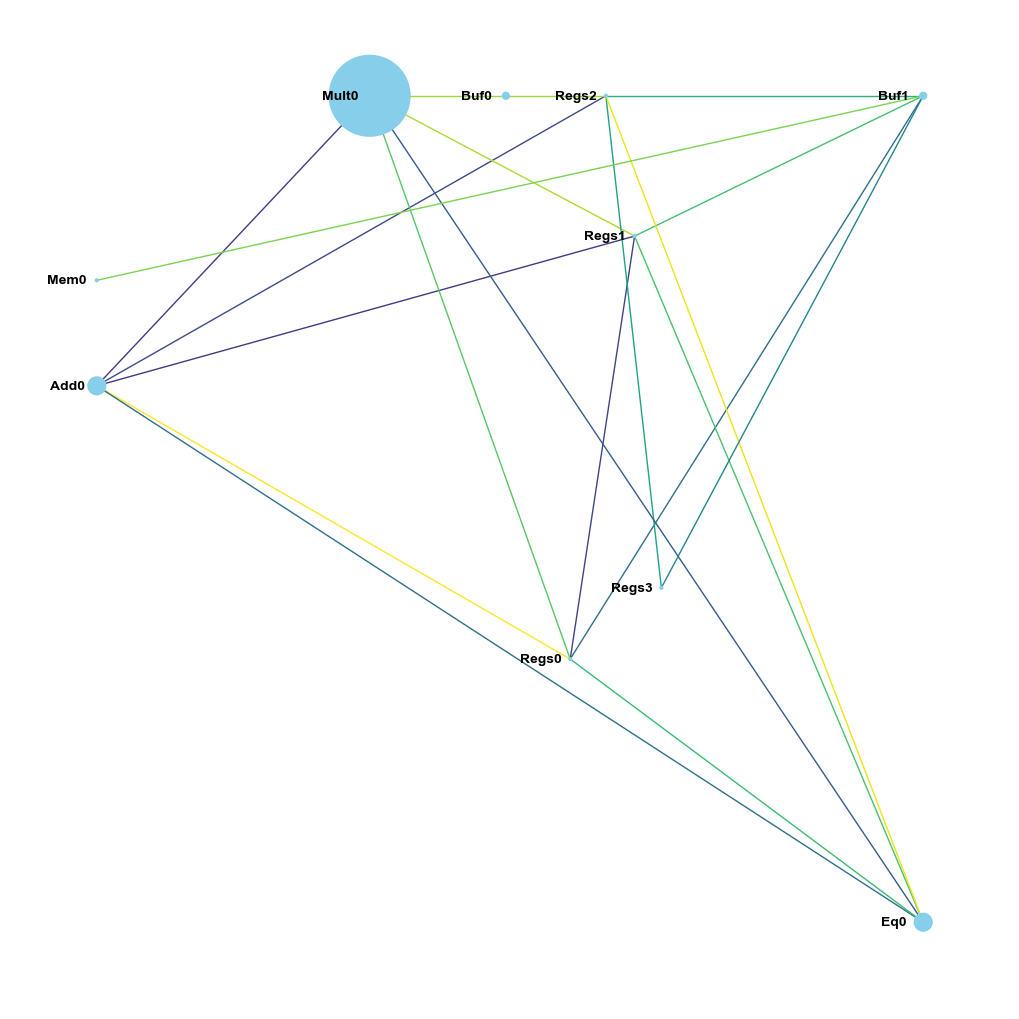

In [143]:
wrapperAnnealing()